# Neural Networks

In the previous part of this exercise, I implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier. In this par, I will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, I will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
%matplotlib inline

Still, we use data set from Machine Learning Course by Stanford, let's look at the given weights.

In [2]:
data = sio.loadmat('ex3data1')#Note, this is a dictionary
wghts = sio.loadmat('ex3weights')
X = data['X'] #Features
y = data['y'] #Digit class
weights = []
Theta1 = wghts['Theta1'] #weights for the hidden layer
Theta2 = wghts['Theta2'] #weights for the output layer
weights.append(Theta1)
weights.append(Theta2)

In [3]:
print 'X size', X.shape
print 'Theta1 size', Theta1.shape
print 'Theta2 size', Theta2.shape

X size (5000L, 400L)
Theta1 size (25L, 401L)
Theta2 size (10L, 26L)


It seems there'a hidden layer in the neural networks, in which there are 25 nodes.

In [63]:
#Shuffle the data and split at random
y[y==10] = 0#Map 10 into 0
#Transform y into a vector of integers directly
y = y.flatten()

## Feedforward Propagation and Prediction

Above all, we need to computer feedforward propagation given input and weights, it is quite easy to do so. And also it is needed for backpropagation.

In [5]:
#Define sigmoid function
def sigmoid(Z):
    return 1/(1 + np.exp(-Z))

In [6]:
#Calculate the accuracy
def accuracy(y, y_test):
    '''Calculate Accuracy'''
    return np.mean(y==y_test)

Note, we need to add biases for the classifier, consequently an extra column of ones are necessary.

In [7]:
#Add oncstants to the original input
#Create theta with theta0
def addOnes(X):
    if X is None:
        print 'Input Null!'
        return None, None
    dim = X.shape
    #If X has multi variables
    if dim>1:
        feature_num = X.shape[1]
        X = np.insert(X, 0, 1, axis=1)
        theta = np.zeros(feature_num+1)
        return X, theta
    #If X only has one variable
    else:
        temp_X = np.ones([len(X), 2])
        temp_X[:, 0] = X
        theta = np.zeros(2)
        return temp_X, theta

Still, choose the index of output column which has the largest probability as the prediction.

In [8]:
#Create a function to do predictions
def modelPredict(test, label_num=10):
    '''Make predictions'''
    if len(test.shape) < 2:
        print 'The input has too few dimensions'
        return None
    #Select the class which has largest probability
    #Note, 10 is mapped into 0
    predictions = [(z.argmax()+1)%label_num for z in test]    
    return predictions

With given input and neural network parameters, we can calculate the output of each layer as well as the final output step by step.

In [9]:
#X: input, 2 dimension numpy array
#weights: weights for each layer, a list
def feedforwardNeuralNetwork(X, weights):
    '''Calculate feedforward propagation output'''
    ######Deal with extreme cases###
    if X is None or weights is None:
        print 'Invalid Input!'
        return None
    dim = X.shape
    if len(dim) < 2:
        print 'X has too less variables'
        return None
    #####Define variables###########
    X, _ = addOnes(X)
    sample_num = len(X)
    feature_num = X.shape[1]
    layer_num = len(weights)
    output_h = []#Output for each layer
    output_h.append(X)#The first layer is equal to input X
    input_z = []#Input for each layer, starts from the second layer
    #####Make alculations for each layer, except the input layer
    for i in range(layer_num):
        z = np.dot(output_h[i], np.transpose(weights[i]))
        h = sigmoid(z)
        if i < layer_num - 1:
            h, _ = addOnes(h)
        output_h.append(h)
        input_z.append(z)
    return h, output_h, input_z    

In [10]:
##Make predictions based on input and layer weights
def neuralNetworkPredict(X, weights):
    h, _, _ = feedforwardNeuralNetwork(X, weights)
    pred = modelPredict(h)
    return pred

In [11]:
pred = neuralNetworkPredict(X, weights)

In [12]:
np.mean(pred==y)

0.97519999999999996

The given parameters works well in classifying the 10 digits.

## Regularized Cost Function

We need to define cost function for a neural network, in order to prevent against overfitting, we take regularization into account. The regularization part consists of sum of all the square values of the parameters except the biases.

In [13]:
#h: probability of y, size is sample number * label number
#y: label, size is sample number * label number, one hot encoder
#weights: weight for each layer, a list
#label_num: label number, 10 for digits
def costFuncWithReg(h, y, weights, lambda1=0.01):
    '''Calculate the cost of neural network'''
    if h is None or y is None or weights is None:
        print 'Invalid Input!'
        return None
    sample_num = len(y)#Length of y
    layer_num = len(weights)
    #Cost of errors
    total = -sum(sum(y*np.log(h)))/sample_num - sum(sum((1-y)*np.log(1-h)))/sample_num
    #Cost of regularization
    for wgt in weights:
        total +=  sum(sum(wgt[:,1:]**2))*lambda1/2/sample_num    
    return total    

In [14]:
#Map each label into a vector
def mapLabelToMatrix(y, label_num=10):
    if y is None:
        print 'Invalid Input!'
        return None
    sample_num = len(y)
    y_mat = np.zeros([sample_num, label_num])
    for i in range(1, label_num+1):
        vec = (y==(i%label_num))#1,2,3,4,5,6,7,8,9,0
        y_mat[:, i-1] = vec#The first column stands for 1, the last for 10
    return y_mat

In [15]:
#Define cost function, X stands for input matrix
#y stands for the labels
#weights stands for the parameters between layers
#lambda1 stands for the regularization coefficient
def calculateCost(X, y_mat, weights, lambda1=0.01):
    '''Calculate the errors of neural network'''
    ###############Deal with unusual inputs###########
    if X is None or y is None:
        print 'Empty Input For Cost!'
        return None

    ##############Map y into matrix####################
    #y_mat = mapLabelToMatrix(y, 10)
    
    #############Compute the cost######################
    h, _, _ = feedforwardNeuralNetwork(X, weights)
    total = costFuncWithReg(h, y_mat, weights, lambda1=lambda1)
    
    return total     

In [16]:
#Map y into matrix: sample num * label num
y_mat = mapLabelToMatrix(y, 10)
calculateCost(X, y_mat, weights, lambda1=1)

0.38376985909092359

## Backpropagation

Now, let's move to the most complex part. In order to train a neural network model, we need to initialize weights.

In [19]:
#Initialize weights
def initializeWeights(n_in, n_out, epsilon=0.12):
    W = np.random.randn(n_out, n_in+1) * 2 * epsilon - epsilon
    return W

In [20]:
#Calculate the gradient of a sigmoid function
def sigmoidGradient(z):
    h = sigmoid(z)
    return h * (1-h)

Next, we need to split the original data set into training part and testing part.

In [21]:
index_shuffle = np.random.permutation(len(y))
training_num = int(len(y) * 0.8)
X_train = X[index_shuffle[:training_num]]
y_train = y[index_shuffle[:training_num]]
X_test = X[index_shuffle[training_num:]]
y_test = y[index_shuffle[training_num:]]

We update the parameters during each iteration.

In [42]:
#Train a neural network model through backpropagation
np.random.seed(111)
sample_num = len(y_train)
input_layer_size = X.shape[1]#Input layer size
label_num = 10#Output class number
weights = []#Weights list, weight for each layer
weights_grad = []#Weights gradient
layer_size = [input_layer_size, 25, label_num]#Node number for each layer
layer_num = len(layer_size) #Number of layer
iter_num = 100000 #Iteration number
alpha = 0.006 #Gradient descending learning rate
lambda1 = 1 #Regularization coefficient
#Transform y into matrix
y_mat = mapLabelToMatrix(y_train, label_num)


#Initialize weights for each layer
for i in range(layer_num-1):
    wgt = initializeWeights(layer_size[i], layer_size[i+1])
    weights.append(wgt)
#Initialize the gradient of weights
for i in range(layer_num-1):
    wgt_grad = np.zeros([layer_size[i+1], layer_size[i]+1])
    weights_grad.append(wgt_grad)
   
J = []#cost for each iteration    
#Learning from the errors
#Using gradient descending method
for _ in range(iter_num):
    h, output_h, input_z = feedforwardNeuralNetwork(X_train, weights)
    cost = costFuncWithReg(h, y_mat, weights, lambda1=lambda1)
    J.append(cost)
    #Backpropagation
    errors = []#errors for each layer
    #Error for the output layer
    error = h - y_mat
    errors.append(error)
    #print error.shape
    #Error for the hidden layer, exclude the input and output error
    for i in range(layer_num-2):
        #Start from the last layer
        layer_index = layer_num - 2 - i
        wgt = weights[layer_index]
        #Remove delta 0, otherwise there will be an error
        error = np.dot(errors[i], wgt)[:,1:] * sigmoidGradient(input_z[i])
        errors.append(error)
    #errors.reverse()#Reverse the order, the hidden layer comes first
    #Calculate accumulated gradients
    Delta = []
    for i in range(len(errors)):
        layer_index = layer_num - 2 - i
        delta =np.dot(np.transpose(errors[i]), output_h[layer_index])
        Delta.append(delta)   
    #Add regularization
    Delta.reverse()
    grad = Delta
    for i in range(len(grad)):
        grad[i] = grad[i] + np.insert(weights[i][:,1:], 0, 0, axis=1) * lambda1
        weights[i] = weights[i] - alpha * grad[i]/sample_num

In [ ]:
Let's check the trend of the costs of iterations.

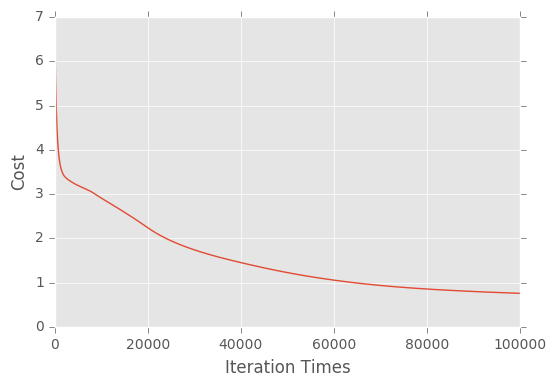

In [43]:
plt.style.use('ggplot')
plt.plot(J)
plt.xlabel('Iteration Times')
plt.ylabel('Cost')

Let's have a look at the training and testing performance.

In [44]:
pred = neuralNetworkPredict(X_train, weights)

In [45]:
np.mean(pred==y_train)

0.92374999999999996

In [46]:
pred = neuralNetworkPredict(X_test, weights)
np.mean(pred==y_test)

0.89200000000000002

It seems the algorithm works, athough the accuracy is not satisfying. We need to tune the parameters such as iteraton numbers and alpha.